# Measuring the performance of Uproot

First, import all modules we are going to use.

In [3]:
import csv
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import sys
import time
import uproot

The two `runtime_measure` functions below return the total runtime of the following operations:  
1. Accessing the `TTree`’s in the ROOT files  
2. Apply specific filters on the data to expose the invariant mass distribution of the B0s meson  
3. Convert the `TBranch` containing the mass of the meson to a `numpy` array  
 
The functions share two common parameters:  
- `path`: the path to the folder containing the ROOT files  
- `n_files`: the number of file you want to process

## 1. Default runtime measurement
The function below measures the runtime when multiprocessing is not used.

In [68]:
def runtime_measure(path, n_files):
    if n_files == 0: return 0
    start = time.time()
    files = [uproot.open(path=path + filename + ":rootuple/CandidateTree", object_cache=None, array_cache=None) for filename in sorted(os.listdir(path))[:n_files]]
    data = []
    for file in files:
        data.append(file.arrays("candidate_vMass", 
                              "(candidate_charge == 0)\
                              & (candidate_cosAlpha > 0.99)\
                              & (candidate_lxy / candidate_lxyErr > 3.0)\
                              & (candidate_vProb > 0.05)\
                              & (ditrack_mass > 1.014) & (ditrack_mass < 1.024)\
                              & (candidate_vMass > 5.33) & (candidate_vMass < 5.4)",
                              array_cache=None,
                              library="np")["candidate_vMass"])
        
    np.concatenate(tuple(data))
    
    return time.time() - start

## 2. Runtime measurement with multiprocessing

First, we need to split the data so that the workload is distributed as equally as possible among all subprocesses. Since **Uproot** allows us to specify the number of entries we want to read from each `TTree`, one entry is our smallest unit of data. This means we can have a distribution in which each subprocess will handle approximately the same number of entries. 

We can distribute the workload with the help of the `partition` function below. It takes 2 parameters:
- `files`: a list of files (the objects returned by `uproot.open`) that will be read. 
- `n_processes`: the number of subprocesses we want to create. 

The function will returns the indices of the first and last entries that one subprocess will read, such that approximately `n_entries` / `n_processes` entries will be distributed to each subprocess, where `n_entries` is the total number of entries in the files.

In [69]:
def partition_helper(slice_entries, file_entries, file_curr, entry_curr):
    if slice_entries <= file_entries[file_curr] - entry_curr:
        return [file_curr, slice_entries + entry_curr]
    elif file_curr == len(file_entries) - 1:
        return [file_curr, file_entries[-1]]
    else:
        return partition_helper(slice_entries - file_entries[file_curr] + entry_curr, file_entries, file_curr + 1, 0)

def partition(files, n_processes):
    file_entries = [file.num_entries for file in files]
    slice_entries = math.ceil(sum(file_entries) / n_processes)
    slices = []
    file_start = 0
    entry_start = 0
    for i in range(n_processes):
        slices.append([file_start, entry_start] + partition_helper(slice_entries, file_entries, file_start, entry_start))
        file_start = slices[-1][-2]
        entry_start = slices[-1][-1]
    return slices

Let's do an example to see how this works. Suppose we want to read the first 5 files in our dataset.

In [70]:
path = "../data/128_files/"
files = [uproot.open(path=path + filename + ":rootuple/CandidateTree", object_cache=None, array_cache=None) for filename in sorted(os.listdir(path))[:5]]

The number of entries in the files are:

In [8]:
for file in files:
    print(file.num_entries) 

3577039
3577039
3577039
3577039
3577039


Now we use `partition` to see how we can distribute this to 4 processes.

In [21]:
partition(files, 4)

[[0, 0, 1, 894260],
 [1, 894260, 2, 1788520],
 [2, 1788520, 3, 2682780],
 [3, 2682780, 4, 3577039]]

The 4 subarrays above indicate what the 4 subprocesses will read. For example, the first subarray means the first subprocess will read from the 0th entry of the 0th file to the 894260th entry of the 1st file. We can verify that this is close to our desired distribution.

In [20]:
print("First process will read %d entries." % (files[0].num_entries + 894260))
print("Second process will read %d entries." % (files[1].num_entries - 894260 + 1788520))
print("Third process will read %d entries." % (files[2].num_entries - 1788520 + 2682780))
print("Fourth process will read %d entries." % (files[3].num_entries - 2682780 + 3577039))
print("Desired number of entries each process will read: %.2f." % (sum([file.num_entries for file in files]) / 4))

First process will read 4471299 entries
Second process will read 4471299 entries
Third process will read 4471299 entries
Fourth process will read 4471298 entries
Desired number of entries each process will read: 4471298.75.


A subprocess can then perform the operations mentioned previously by calling `read_slice`. It takes 4 parameters:
- `files`: a list of files (the objects returned by `uproot.open`) that will be read. 
- `slices`: the array returned by `partition`. 
- `index`: the index of the subprocess.
- `result`: a list shared among all subprocesses

The function will add the `numpy` arrays containing the mass of the B0s meson to `result`. After the last subprocess finishes, all arrays in `result` will be concatenated together.

In [71]:
def read_slice(files, slices, index, result):
    data_slice = []
    for i in range(slices[index][0], slices[index][2] + 1):
        data_slice.append(files[i].arrays("candidate_vMass", 
                              "(candidate_charge == 0)\
                              & (candidate_cosAlpha > 0.99)\
                              & (candidate_lxy / candidate_lxyErr > 3.0)\
                              & (candidate_vProb > 0.05)\
                              & (ditrack_mass > 1.014) & (ditrack_mass < 1.024)\
                              & (candidate_vMass > 5.33) & (candidate_vMass < 5.4)",
                              entry_start=slices[index][1] if i == slices[index][0] else None,
                              entry_stop=slices[index][3] if i == slices[index][2] else None,
                              array_cache=None,
                              library="np")["candidate_vMass"])
    result.append(np.concatenate(tuple(data_slice)))

Finally, `runtime_measure_mp` measures the runtime of **Uproot** using explicit multiprocessing.

In [72]:
def runtime_measure_mp(path, n_files, n_processes):
    if n_files == 0: return 0
    if n_processes == 0: return runtime_measure(path, n_files)
    start = time.time()
    files = [uproot.open(path=path + filename + ":rootuple/CandidateTree", object_cache=None, array_cache=None) for filename in sorted(os.listdir(path))[:n_files]]
    slices = partition(files, n_processes)
    result = multiprocessing.Manager().list()
    processes = []
    for i in range(n_processes):
        p = multiprocessing.Process(target=read_slice, args=[files, slices, i, result])
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
    
    np.concatenate(tuple(result))
    
    return time.time() - start

## Run the measurements multiple times and save the results

`runtime_vs_variable` runs one of the `runtime_measure` functions above multiple times with varying number of processes or files, and then saves the result in a csv file. The file can then be used to produce a plot with the variable on the x-axis and runtime on the y-axis.

### List of parameters:
- `path`: path to the directory containing the ROOT files.
- `target_dir`: path to the directory where the resulting csv file will be stored.
- `measure_function`: reference to one of the `runtime_measure` functions above.
- `variable`: a string indicating the varying parameter. Can have the following values:
    - `"processes"`: the number of files is constant, while the number of subprocesses varies.
    - `"size"`: the number of files varies. Implicit multithreading is used without specifying the number of threads.
    - `"size_mp"`: the number of files varies. Multiprocessing is used with a constant number of subprocesses.
- `step`: difference between 2 consective x-values.
- `n_loops`: the number of times each measurement is repeated.
- `var_max`: the maximum value of the variable (x).
- `constant`: the value of the constant. When parallelism is not used, this is not needed adn is set to `None`.

### Resulting csv file:
The name of the resulting csv files indicates the arguments passed to the function.
Examples:
- `runtime_vs_processes_128_128_4_20.csv`: the number of **processes** varies, the number of files is constant and equals **128**, the maximum number of processes used is **128**, the number of processes is incremented by **4** each time, and every measurement is repeated **20** times.
- `runtime_vs_size_mp_32_128_4_20.csv`: the number of files (**size**) varies, **m**ulti**p**rocessing is used with **32** subprocesses, the maximum number of files read is **128**, the number of files is incremented by **4** each time, and every measurement is repeated **20** times.

In [6]:
def runtime_vs_variable(path, target_dir, measure_function, variable, step, n_loops, var_max, constant=None):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    result_path = ("%s/runtime_vs_%s_%d_%d_%d_%d.csv" % (target_dir, variable, constant, var_max, step, n_loops)) if constant else ("%s/runtime_vs_%s_%d_%d_%d.csv" % (target_dir, variable, var_max, step, n_loops))
    
    x = [a for a in range(0, var_max + step, step)]
    
    if not os.path.exists(result_path):
        with open(result_path, "w", newline="") as f:
            csv.writer(f).writerow(x)
    for n in range(n_loops):
        with open(result_path, "r") as f:
            if sum(1 for row in csv.reader(f)) == n_loops + 1: break
        y = [measure_function(*(path, i if "size" in variable else constant, constant if "size" in variable else i) if constant else (path, i)) for i in range(0, var_max + step, step)]
        with open(result_path, "a", newline="") as f:
            csv.writer(f).writerow(y)

## Example

First, let's set the path to the ROOT files and the target directory.

In [22]:
path = "../data/128_files/"
target_dir = "runtime_tests_rdf/128_files/wn-gpu-8-3-22"

Now we can run the measurements. This will take a long time, so it's recommended to run the Python file `runtime_measurement_uproot.py` in a screen instead.

In [23]:
# runtime_vs_variable(path, target_dir, runtime_measure_mp, "processes", 4, 20, 128, 32)
# runtime_vs_variable(path, target_dir, runtime_measure_mp, "size_mp", 4, 20, 128, 64)
# runtime_vs_variable(path, target_dir, runtime_measure, "size", 4, 20, 128)

Let's plot the result.

In [25]:
from ipynb.fs.defs.plot import plot

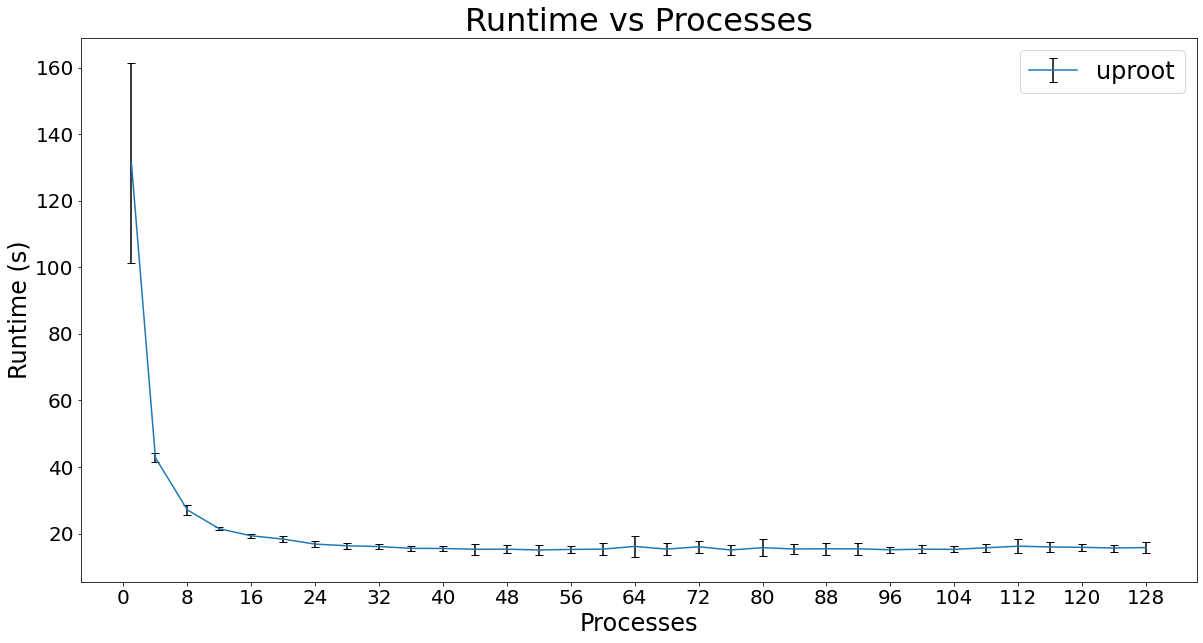

In [26]:
plot(path,
     'Runtime vs Processes',
     'Processes',
     'Runtime (s)',
     "runtime_tests_uproot/128_files/wn-gpu-8-3-22/runtime_vs_processes_128_128_4_20.csv",
     "uproot",
     plot_type="errorbars"
    )

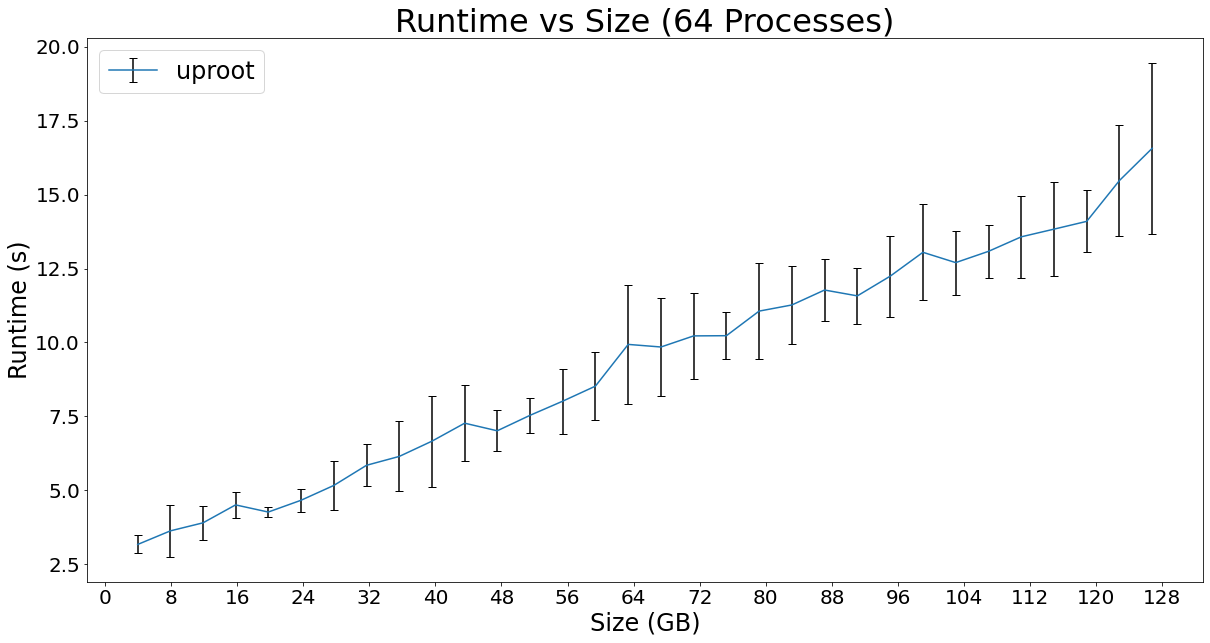

In [27]:
plot(path,
     'Runtime vs Size (64 Processes)',
     'Size (GB)',
     'Runtime (s)',
     "runtime_tests_uproot/128_files/wn-gpu-8-3-22/runtime_vs_size_mp_64_128_4_20.csv",
     "uproot",
     plot_type="errorbars"
    )

## Some extra details

The `runtime_measure_mp_detailed` function below do the same thing as `runtime_measure_mp`, but it prints out the total runtime, the time it takes to open all the files using **Uproot**, and the runtime of each subprocess.

In [28]:
# def partition_files(path, n_files, n_processes):
#     filenames = sorted(os.listdir(path))
#     partitions = []
#     curr = 0
#     for i in range(n_processes):
#         if i >= n_files: break
#         n_files_in_partition = n_files // n_processes if i >= n_files % n_processes else n_files // n_processes + 1
#         files_to_read = []
#         for j in range(n_files_in_partition):
#             files_to_read.append(path + filenames[curr + j])
#         curr += n_files_in_partition
#         partitions.append(files_to_read)
#     return partitions

In [29]:
def read_slice_detailed(files, slices, index, data, process_runtimes):
    key = "P%d" % (index)
    start_time = time.time()
    data_slice = []
    for i in range(slices[index][0], slices[index][2] + 1):
        data_slice.append(files[i].arrays("candidate_vMass", 
                                          "(candidate_charge == 0)\
                                          & (candidate_cosAlpha > 0.99)\
                                          & (candidate_lxy / candidate_lxyErr > 3.0)\
                                          & (candidate_vProb > 0.05)\
                                          & (ditrack_mass > 1.014) & (ditrack_mass < 1.024)\
                                          & (candidate_vMass > 5.33) & (candidate_vMass < 5.4)",
                                          entry_start=slices[index][1] if i == slices[index][0] else None,
                                          entry_stop=slices[index][3] if i == slices[index][2] else None,
                                          array_cache=None,
                                          library="np",
                                         )["candidate_vMass"])
    data.append(np.concatenate(tuple(data_slice)))
    runtime = time.time() - start_time
    
    process_runtimes[key] = runtime

In [30]:
def runtime_measure_mp_detailed(path, n_files, n_processes):
    start_time = time.time()
    
    start_time2 = time.time()
    files = [uproot.open(path=path + filename + ":rootuple/CandidateTree", object_cache=None, array_cache=None) for filename in sorted(os.listdir(path))[:n_files]]
#     files = open_mp(path, n_files, 8)
    runtime2 = time.time() - start_time2
    slices = partition(files, n_processes)

    processes = []
    data = multiprocessing.Manager().list()
    process_runtimes = multiprocessing.Manager().dict()
    
    for i in range(n_processes):
        p = multiprocessing.Process(target=read_slice_detailed, args=[files, slices, i, data, process_runtimes])
        p.start()
        processes.append(p)
        
    for p in processes:
        p.join()
    
    np.concatenate(tuple(data))
    
    runtime = time.time() - start_time
    
    return runtime, runtime2, dict(process_runtimes)

In [31]:
runtime_measure_mp_detailed(path, 128, 32)

(14.700944900512695,
 8.491154909133911,
 {'P0': 4.196753263473511,
  'P31': 4.0130393505096436,
  'P3': 4.857957601547241,
  'P2': 4.892945289611816,
  'P5': 4.888693809509277,
  'P6': 4.889856338500977,
  'P4': 4.931567430496216,
  'P10': 4.8835508823394775,
  'P9': 4.898370265960693,
  'P1': 4.969764232635498,
  'P11': 4.911620616912842,
  'P7': 4.948460102081299,
  'P12': 4.932305574417114,
  'P13': 4.94188928604126,
  'P15': 4.973782777786255,
  'P23': 4.922181129455566,
  'P17': 4.980968713760376,
  'P14': 5.016452312469482,
  'P16': 5.002764701843262,
  'P19': 4.978670597076416,
  'P20': 4.98385763168335,
  'P18': 5.0085365772247314,
  'P21': 4.998082637786865,
  'P25': 4.965678930282593,
  'P22': 5.0146777629852295,
  'P27': 4.981723785400391,
  'P26': 4.997420072555542,
  'P24': 5.033779859542847,
  'P29': 4.9867658615112305,
  'P28': 5.008619785308838,
  'P30': 5.0173890590667725,
  'P8': 5.860700607299805})

# Test

In [60]:
def partition_test(file_entries, n_processes):
    slice_entries = math.ceil(sum(file_entries) / n_processes)
    slices = []
    file_start = 0
    entry_start = 0
    for i in range(n_processes):
        slices.append([file_start, entry_start] + partition_helper(slice_entries, file_entries, file_start, entry_start))
        file_start = slices[-1][-2]
        entry_start = slices[-1][-1]
    return slices

In [61]:
def read_slice_test(paths, slices, index, result):
    data_slice = []
    for i in range(slices[index][0], slices[index][2] + 1):
        data_slice.append(uproot.open(paths[i], object_cache=None, array_cache=None).arrays("candidate_vMass", 
                              "(candidate_charge == 0)\
                              & (candidate_cosAlpha > 0.99)\
                              & (candidate_lxy / candidate_lxyErr > 3.0)\
                              & (candidate_vProb > 0.05)\
                              & (ditrack_mass > 1.014) & (ditrack_mass < 1.024)\
                              & (candidate_vMass > 5.33) & (candidate_vMass < 5.4)",
                              entry_start=slices[index][1] if i == slices[index][0] else None,
                              entry_stop=slices[index][3] if i == slices[index][2] else None,
                              array_cache=None,
                              library="np")["candidate_vMass"])
    result.append(np.concatenate(tuple(data_slice)))

In [90]:
def runtime_measure_mp_test(path, n_files, n_processes):
    if n_files == 0: return 0
    if n_processes == 0: return runtime_measure(path, n_files)
    start = time.time()
    paths = [path + filename + ":rootuple/CandidateTree" for filename in sorted(os.listdir(path))[:n_files]]
    file_entries = [n[2] for n in uproot.num_entries([path + filename + ":rootuple/CandidateTree" for filename in sorted(os.listdir(path))])]
    slices = partition_test(file_entries, n_processes)
    result = multiprocessing.Manager().list()
    processes = []
    for i in range(n_processes):
        p = multiprocessing.Process(target=read_slice_test, args=[paths, slices, i, result])
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
    
    np.concatenate(tuple(result))
    
    return time.time() - start

In [91]:
runtime_measure_mp_test(path, 128, 64)

5.213811874389648

In [87]:
runtime_measure_mp(path, 128, 128)

17.230513334274292